import some modules:

In [1]:
import json, urllib, numpy as np, matplotlib.pylab as plt, matplotlib.ticker as mtick, requests
import sunpy.map
import drms
from astropy.io import fits
from sunpy.cm import color_tables as ct
import sunpy.wcs as wcs
from datetime import datetime as dt_obj
import matplotlib.dates as mdates
import matplotlib.colors as mcol
import matplotlib.patches as ptc
from matplotlib.dates import *
import math

/anaconda3/lib/python3.6/site-packages/sunpy/wcs/__init__.py:61: SunpyDeprecationWarning: As of v0.8.0, the `sunpy.wcs` module is deprecated and will be removed in a future version. Use `sunpy.coordinates` or `sunpy.map` for coordinate transformations.
  SunpyDeprecationWarning)


Open a client to get data from JSOC

In [10]:
import drms
c = drms.Client()

In [11]:
keys_aia, segments = c.query('aia.lev1[2012.03.06_23:29:06_TAI/12s][?WAVELNTH=1600?]', key='T_REC,CROTA2,CDELT1,CDELT2,CRPIX1,CRPIX2,CRVAL1,CRVAL2', seg='image_lev1')
url_aia = 'http://jsoc.stanford.edu' + segments.image_lev1[0]   # add the jsoc.stanford.edu suffix to the segment name
chromosphere_image = fits.open(url_aia       )                  # download the data

/anaconda3/lib/python3.6/site-packages/drms/client.py:1089: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res_key = pd.DataFrame.from_items(zip(names, values))
/anaconda3/lib/python3.6/site-packages/drms/client.py:1100: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res_seg = pd.DataFrame.from_items(zip(names, values))


We queried for a few keywords. We'll need these keywords later to coalign these data with others. For the AIA data, this is what they mean:

+ *T_REC* indicates the time the image was taken (technically the mid-point of the integration time),
+ *CROTA2* indicates the rotation of the camera with respect to the fixed Sun in degrees,
+ *CDELT1n* indicates the platescale of the instrument in arseconds per pixel,
+ *CRPIXn* indicates the the location of the center of the Sun on the CCD in pixels, and
+ *CRVALn* indicates the same thing as *CRPIXn*, but in arcseconds.

/anaconda3/lib/python3.6/site-packages/sunpy/map/sources/sdo.py:48: SunpyDeprecationWarning: Use Matplotlib to load the colormaps
  self.plot_settings['cmap'] = cm.get_cmap(self._get_cmap_name())
/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


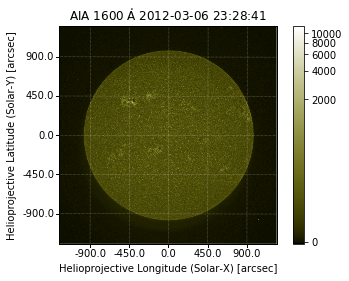

In [12]:
sunpy.map.Map(url_aia).peek()
plt.show()

The Helioseismic and Magnetic Imager (HMI), another instrument aboard SDO, takes images of the solar surface, or photosphere. Here's an image of the photosphere taken at the same time as the chromospheric image above. You can see that it is rotated 180 degrees with respect to the AIA image, which is why it is important for us to take the *CROTA2* value for each instrument into consideration when doing any array manipulation.

/anaconda3/lib/python3.6/site-packages/drms/client.py:1089: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res_key = pd.DataFrame.from_items(zip(names, values))
/anaconda3/lib/python3.6/site-packages/drms/client.py:1100: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res_seg = pd.DataFrame.from_items(zip(names, values))


/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


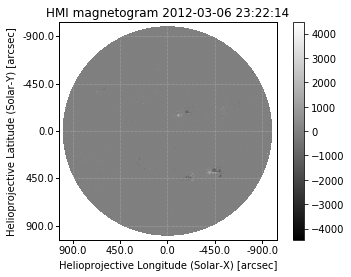

In [13]:
keys_hmi, segments = c.query('hmi.M_720s[2012.03.06_23:29:06_TAI]', key=drms.const.all, seg='magnetogram')
url_hmi = 'http://jsoc.stanford.edu' + segments.magnetogram[0]   # add the jsoc.stanford.edu suffix to the segment name
photosphere_full_image = fits.getdata(url_hmi)                   # download the image data

header = dict(keys_hmi.iloc[0])

# Add a DATE-OBS keyword which seems to be required by sunpy.map.Map.
header['DATE-OBS'] = keys_hmi.DATE__OBS[0]

# Add HGLN_OBS keyword to avoid a warning in sunpy.map.Map.
header['HGLN_OBS'] = 0.0

sunpy.map.Map(photosphere_full_image, header).peek()
plt.show()

### Identifying which AIA pixels are included in the CCD-coordinate SHARP bounding box

Query for CCD-coordinate SHARP data:

In [8]:
keys_ccd, segments = c.query('hmi.sharp_720s[1449][2012.03.06_23:29:06_TAI]', key=drms.const.all, seg='magnetogram')
url_ccd = 'http://jsoc.stanford.edu' + segments.magnetogram[0]   # add the jsoc.stanford.edu suffix to the segment name
photosphere_image = fits.open(url_ccd)                           # download the data
XDIM_CCD = photosphere_image[1].data.shape[1]
YDIM_CCD = photosphere_image[1].data.shape[0]

/anaconda3/lib/python3.6/site-packages/drms/client.py:1089: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res_key = pd.DataFrame.from_items(zip(names, values))
/anaconda3/lib/python3.6/site-packages/drms/client.py:1100: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res_seg = pd.DataFrame.from_items(zip(names, values))


In addition to downloading the patch data, we also need some metadata. For the HMI SHARP Helioprojective Cartesian CCD image coordinate data, this is what they mean:  
  
  + *CRPIXn* indicates the location, in pixels, of disk center with respect to the lower left-hand corner of the patch,
  + *CROTA2* indicates the rotation of the camera with respect to the fixed Sun in degrees,
  + *CDELTn* indicates the platescale of the instrument, in arcseconds per pixel, and
  + *XDIM* and *YDIM* give the x and y-dimensions of the image, respectively, in pixels.

Then we must make sure that the angle between the HMI camera and the fixed Sun is approximately zero; otherwise, we'll rotate the image to ensure this is so.

In [14]:
if (keys_ccd.CROTA2[0] > 5.0):
    print("The HMI camera rotation angle is",keys_ccd.CROTA2[0],". Rotating HMI images.")
    photosphere_full_image = np.rot90(photosphere_full_image,2)
    photosphere_image[1].data = np.rot90(photosphere_image[1].data,2)

The HMI camera rotation angle is 180.082581 . Rotating HMI images.


Now we can plot HARP number 1449 at this T_REC in CCD coordinates

The dimensions of this image are 480 by 1056 .


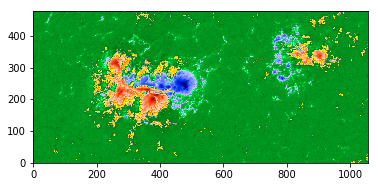

In [15]:
hmimag = plt.get_cmap('hmimag')
plt.imshow(photosphere_image[1].data,cmap=hmimag,origin='lower')
print('The dimensions of this image are',photosphere_image[1].data.shape[0],'by',photosphere_image[1].data.shape[1],'.')

Identify the area on the full-disk photospheric image in CCD coordinates for a sanity check:

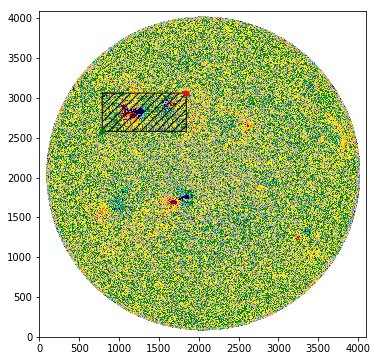

In [18]:
fig, ax = plt.subplots(1,1)
plt.imshow(photosphere_full_image,cmap=hmimag,origin='lower',vmax=300,vmin=-300,extent=[0,4096,0,4096])
y1 = (2048. + keys_ccd.CRPIX2[0] - YDIM_CCD)  
y2 = (2048. + keys_ccd.CRPIX2[0])
x1 = (2048. + keys_ccd.CRPIX1[0] - XDIM_CCD)
x2 = (2048. + keys_ccd.CRPIX1[0])

# draw a box using matplotlib.patches.Rectangle
ax.add_patch(ptc.Rectangle((x1, y1), XDIM_CCD, YDIM_CCD, hatch='///', fill=False, snap=False))

# plot a green dot at the lower left-hand corner
plt.plot(x1, y1, 'g.', markersize=10.0)

# plot a red dot at the upper right-hand corner
plt.plot(x2, y2, 'r.', markersize=10.0)
fig.set_size_inches(6,6)

If we are interested in cutting a SHARP-sized box out of AIA data, the first thing we can do is compute the ratio of the platescales. Since HMI and AIA are not observing in the same wavelength, the radius of the solar disk is different in both images and, as a result, the platescale is too:

In [19]:
ratio = (keys_ccd.CDELT1[0])/(keys_aia.CDELT1[0])
print("The ratio of the HMI:AIA platescales is",ratio,".")

The ratio of the HMI:AIA platescales is 0.8275571776235573 .


Now we can cut the same sized array out of the AIA data. We first have to use the astropy package to fix the FITS header as some of the AIA keywords have non-standard values. Then we must again make sure that the angle between the camera and the fixed Sun is approximately zero; otherwise, we'll rotate the image to ensure this is so.

In [21]:
chromosphere_image.verify("fix")
if (keys_aia.CROTA2[0] > 5.0):
    print("The AIA camera rotation angle is",keys_aia.CROTA2[0],". Rotating AIA image.")
    chromosphere_image[1].data = np.rot90(chromosphere_image[1].data,2)

 [astropy.io.fits.verify]


In [22]:
y1 = int(np.rint(2048. + keys_ccd.CRPIX2[0]*(ratio) - YDIM_CCD*(ratio)))
y2 = int(np.rint(2048. + keys_ccd.CRPIX2[0]*(ratio)))
x1 = int(np.rint(2048. + keys_ccd.CRPIX1[0]*(ratio) - XDIM_CCD*(ratio)))
x2 = int(np.rint(2048. + keys_ccd.CRPIX1[0]*(ratio)))

In [23]:
subdata = chromosphere_image[1].data[y1:y2, x1:x2]

Plot the subdata:

The dimensions of this image are 397 by 874 .


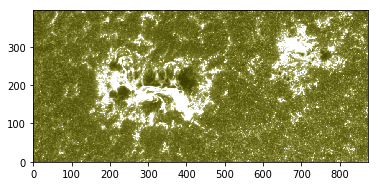

In [25]:
sdoaia1600 = plt.get_cmap('sdoaia1600')
plt.imshow(subdata,cmap=sdoaia1600,origin='lower',vmin=0,vmax=400)
print('The dimensions of this image are',subdata.shape[0],'by',subdata.shape[1],'.')

### Identifying which AIA pixels are included in the CEA-coordinate SHARP bounding boxÂ¶

For CEA-coordinate SHARP data. The CEA data are useful for two reasons:

1. Each pixel is of an equal area, so derivatives or other such numerical computations are straightforward, and
2. The space-weather keywords included in the SHARP metadata, which characterize the photospheric vector magnetic field, are computed using the CEA data; as such, computing a feature using a CEA-sized cutout of the AIA data allows for easy comparison between the space-weather keywords and any feature derived from the AIA data.

In [26]:
keys_cea, segments = c.query('hmi.sharp_cea_720s[1449][2012.03.06_23:29:06_TAI]', key=drms.const.all, seg='magnetogram')
url_cea = 'http://jsoc.stanford.edu' + segments.magnetogram[0]   # add the jsoc.stanford.edu suffix to the segment name
cea_image = fits.open(url_cea)                           # download the data
XDIM_CEA = cea_image[1].data.shape[1]
YDIM_CEA = cea_image[1].data.shape[0]

/anaconda3/lib/python3.6/site-packages/drms/client.py:1089: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res_key = pd.DataFrame.from_items(zip(names, values))
/anaconda3/lib/python3.6/site-packages/drms/client.py:1100: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res_seg = pd.DataFrame.from_items(zip(names, values))


This is what the keywords mean in the Carrington Heliographic Cylindrical Equal-Area coordinate system:

+ CRLT_OBS indicates the Carrington latitude of the observer in degrees,
+ CDELTn indicates the platescale of the image in degrees per pixel, which, per the definition of equal-area, is always constant (0.03 degrees per pixel),
+ CRVALn indicates the longitude and latitude at the center of the patch, in degrees,
+ CRLN_OBS indicates the Carrington longitude of the observer in degrees, and
+ XDIM and YDIM give the x and y-dimensions of the image, respectively, in pixels.

The dimensions of this CEA-projected image are 460 by 1167 .


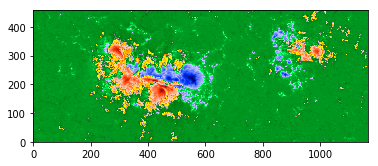

In [27]:
plt.imshow(cea_image[1].data,cmap=hmimag,origin='lower')
print('The dimensions of this CEA-projected image are',cea_image[1].data.shape[0],'by',cea_image[1].data.shape[1],'.')

To map the CEA data to the AIA data. We first convert the latitude and longitude at the center of the patch from the Carrington Heliographic coordinate system, which has units of degrees, to Helioprojective Cartesian coordinates, which has units of arcseconds. To do this, we use SunPy's WCS module. After we know the center of the patch in units of arcseconds, we can use the platescale to convert it to units of AIA pixels. Let's plot three points, indicating the center, upper right-hand corner, and lower left-hand corner of the CEA bounding box on the AIA data:

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: SunpyDeprecationWarning: The convert_hg_hpc function is deprecated and may be removed in a future version.
        Use sunpy.coordinates instead.
  # This is added back by InteractiveShellApp.init_path()
/anaconda3/lib/python3.6/site-packages/sunpy/wcs/wcs.py:427: SunpyDeprecationWarning: The convert_hg_hcc function is deprecated and may be removed in a future version.
        Use sunpy.coordinates instead.
  tempx, tempy = convert_hg_hcc(hglon_deg, hglat_deg, b0_deg=b0_deg, l0_deg=l0_deg, occultation=occultation)
/anaconda3/lib/python3.6/site-packages/sunpy/wcs/wcs.py:428: SunpyDeprecationWarning: The convert_hcc_hpc function is deprecated and may be removed in a future version.
        Use sunpy.coordinates instead.
  x, y = convert_hcc_hpc(tempx, tempy, dsun_meters=dsun_meters, angle_units=angle_units)
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:28: SunpyDeprecationWarning: The convert_hg_hpc function 

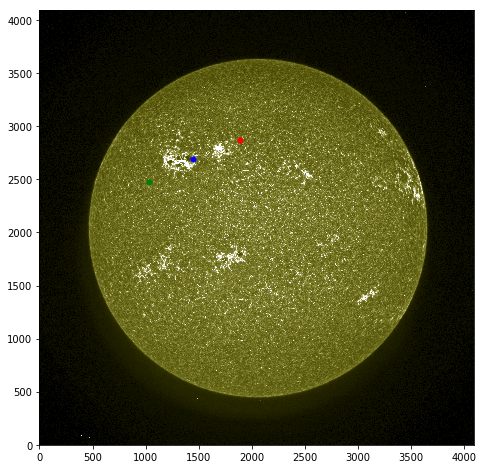

In [28]:
fig, ax = plt.subplots(1,1)
plt.imshow(chromosphere_image[1].data,origin='lower',cmap=sdoaia1600,vmin=0,vmax=400,extent=[0,4096,0,4096])

# [1] plot a blue dot at the center of the CEA box on the AIA image:

# convert from Carrington Heliographic to Helioprojective Cartesian coordinates
# CRVALn_CEA is the center of the CEA box in Carrington Heliographic coordinates (degrees)
# CRLT_OBS_CEA is the Heliographic latitude of the observer in (degrees)
# CRLN_OBS_CEA is the Carrington longitude of the observer in (degrees)
# thus HPC_out is the center of the CEA box in Helioprojective-Cartesian coordinates (arcsec)
HPC_out = wcs.convert_hg_hpc(keys_cea.CRVAL1[0], keys_cea.CRVAL2[0], b0_deg=keys_cea.CRLT_OBS[0], l0_deg=keys_cea.CRLN_OBS[0])

# CRPIXn_AIA is the center of the AIA image in AIA pixels
# CDELT1_AIA is the platescale of the AIA data in arcsec/AIA pixel
# thus (xc,yc) is the center of the CEA box in AIA pixels
xc = ((HPC_out[0])/keys_aia.CDELT1[0]) + keys_aia.CRPIX1[0]
yc = ((HPC_out[1])/keys_aia.CDELT1[0]) + keys_aia.CRPIX2[0]
plt.plot(xc, yc, 'b.', markersize=10.0)

# [2] plot a green dot at the lower left-hand corner of the CEA box on the AIA image:
# mDIM_CEA are the dimensions of the CEA box in HMI pixels
# CDELT1_CEA is the platescale of the CEA image in degrees/CEA pixel
# thus (x1,y1) is the lower left-hand corner of the CEA image in Carrington Heliographic coordinates (degrees)
x1 = keys_cea.CRVAL1[0] - 0.5*XDIM_CEA*keys_cea.CDELT1[0]
y1 = keys_cea.CRVAL2[0] - 0.5*YDIM_CEA*keys_cea.CDELT1[0]

# convert from Carrington Heliographic to Helioprojective Cartesian coordinates
HPC_out = wcs.convert_hg_hpc(x1, y1, b0_deg=keys_cea.CRLT_OBS[0], l0_deg=keys_cea.CRLN_OBS[0])
x1 = ((HPC_out[0])/keys_aia.CDELT1[0]) + keys_aia.CRPIX1[0]
y1 = ((HPC_out[1])/keys_aia.CDELT1[0]) + keys_aia.CRPIX2[0]
plt.plot(x1, y1, 'g.', markersize=10.0)

# [2] plot a red dot at the upper right-hand corner of the CEA box on the AIA image:
# mDIM_CEA are the dimensions of the CEA box in HMI pixels
# CDELT1_CEA is the platescale of the CEA image in degrees/CEA pixel
# thus (x1,y1) is the lower left-hand corner of the CEA image in Carrington Heliographic coordinates (degrees)
x2 = keys_cea.CRVAL1[0] - 0.5*XDIM_CEA*keys_cea.CDELT1[0] + XDIM_CEA*keys_cea.CDELT1[0]
y2 = keys_cea.CRVAL2[0] - 0.5*YDIM_CEA*keys_cea.CDELT1[0] + YDIM_CEA*keys_cea.CDELT1[0]

# convert from Carrington Heliographic to Helioprojective Cartesian coordinates
HPC_out = wcs.convert_hg_hpc(x2, y2, b0_deg=keys_cea.CRLT_OBS[0], l0_deg=keys_cea.CRLN_OBS[0])
x2 = ((HPC_out[0])/keys_aia.CDELT1[0]) + keys_aia.CRPIX1[0]
y2 = ((HPC_out[1])/keys_aia.CDELT1[0]) + keys_aia.CRPIX2[0]
plt.plot(x2, y2, 'r.', markersize=10.0)

fig.set_size_inches(8,8)

Naively, we might want to draw a bounding box connecting the green and red dots. But because the CEA data is projected, the bounding box is not a rectangular shape in CCD coordinates. Thus we will identify which AIA pixels lie within the CEA bounding box by using a mask:

In [30]:
aia_mask = np.full([4096,4096], np.nan)

for j in range(int(YDIM_CEA)):
    for i in range(int(XDIM_CEA)):
        x_hg = keys_cea.CRVAL1[0] - 0.5*XDIM_CEA*keys_cea.CDELT1[0] + i*keys_cea.CDELT1[0]
        y_hg = keys_cea.CRVAL2[0] - 0.5*YDIM_CEA*keys_cea.CDELT1[0] + j*keys_cea.CDELT1[0]
        HPC_out = wcs.convert_hg_hpc(x_hg, y_hg, b0_deg=keys_cea.CRLT_OBS[0], l0_deg=keys_cea.CRLN_OBS[0])
        x_aia = int(((HPC_out[0])/keys_aia.CDELT1[0]) + keys_aia.CRPIX1[0])
        y_aia = int(((HPC_out[1])/keys_aia.CDELT1[0]) + keys_aia.CRPIX2[0])
        aia_mask[y_aia,x_aia] = 1.0

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: SunpyDeprecationWarning: The convert_hg_hpc function is deprecated and may be removed in a future version.
        Use sunpy.coordinates instead.
  import sys
/anaconda3/lib/python3.6/site-packages/sunpy/wcs/wcs.py:427: SunpyDeprecationWarning: The convert_hg_hcc function is deprecated and may be removed in a future version.
        Use sunpy.coordinates instead.
  tempx, tempy = convert_hg_hcc(hglon_deg, hglat_deg, b0_deg=b0_deg, l0_deg=l0_deg, occultation=occultation)
/anaconda3/lib/python3.6/site-packages/sunpy/wcs/wcs.py:428: SunpyDeprecationWarning: The convert_hcc_hpc function is deprecated and may be removed in a future version.
        Use sunpy.coordinates instead.
  x, y = convert_hcc_hpc(tempx, tempy, dsun_meters=dsun_meters, angle_units=angle_units)


This is what the mask looks like:

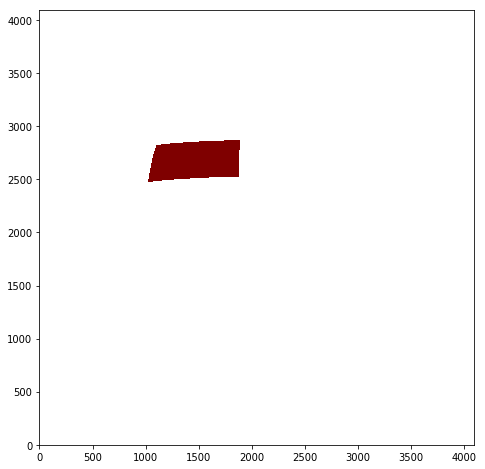

In [31]:
fig, ax = plt.subplots(1,1)
plt.imshow(aia_mask,origin='lower',vmin=0,vmax=1.0,cmap='seismic',extent=[0,4096,0,4096])
fig.set_size_inches(8,8)

The masked AIA image:

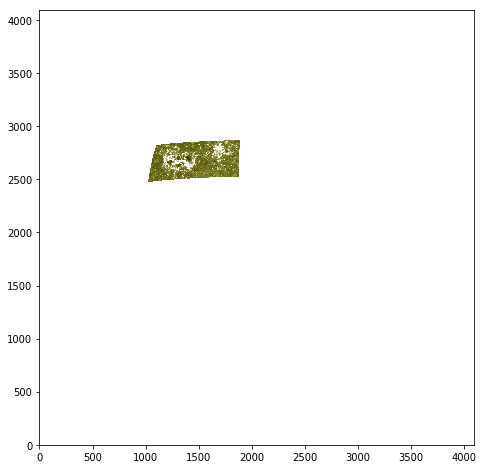

In [32]:
aia_masked_data = chromosphere_image[1].data*aia_mask

fig, ax = plt.subplots(1,1)
plt.imshow(aia_masked_data,origin='lower',vmin=0,vmax=400.0,cmap=sdoaia1600,extent=[0,4096,0,4096])
fig.set_size_inches(8,8)

Zoom in:

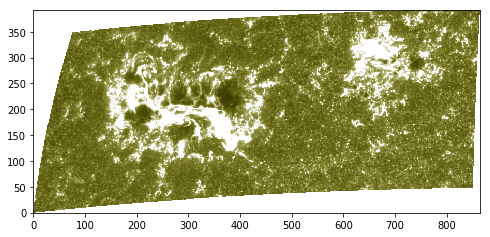

In [33]:
fig, ax = plt.subplots(1,1)
plt.imshow(aia_masked_data[int(y1):int(y2),int(x1):int(x2)],origin='lower',vmin=0,vmax=400.0,cmap=sdoaia1600)
fig.set_size_inches(8,8)